In [ ]:
# SETUP & LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

# Configuration
DATA_PATH = Path("trips_2018.csv") 
FIG_DIR = Path("./FIGURES_FINAL")
FIG_DIR.mkdir(exist_ok=True)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.titlesize': 14})

Libraries loaded. Figures will be saved to: FIGURES_FINAL


In [ ]:
# TASK 1: SPATIAL CLUSTERING

print("Step 1: Loading station coordinates for clustering...")

# We only need station metadata first. 
# Reading a subset or unique stations is efficient.
# Since the file is huge, we'll read in chunks to find unique stations.
station_coords = {}

chunksize = 500_000
for chunk in pd.read_csv(DATA_PATH, chunksize=chunksize, 
                         usecols=['start_station_id', 'start_station_latitude', 'start_station_longitude']):
    # Drop NAs and duplicates in chunk
    chunk = chunk.dropna().drop_duplicates('start_station_id')
    for _, row in chunk.iterrows():
        sid = int(row['start_station_id'])
        if sid not in station_coords:
            station_coords[sid] = (row['start_station_latitude'], row['start_station_longitude'])

# Convert to DataFrame
stations_df = pd.DataFrame.from_dict(station_coords, orient='index', columns=['lat', 'lon'])
stations_df.index.name = 'station_id'
print(f"Found {len(stations_df)} unique stations.")

# --- K-MEANS CLUSTERING ---
# Theory: We use K-Means to partition stations based on Euclidean distance.
# K=20 is the minimum requirement; K=24 is chosen to roughly map to 'districts'.
K = 24
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
stations_df['cluster'] = kmeans.fit_predict(stations_df[['lat', 'lon']])


Step 1: Loading station coordinates for clustering...
Found 818 unique stations.


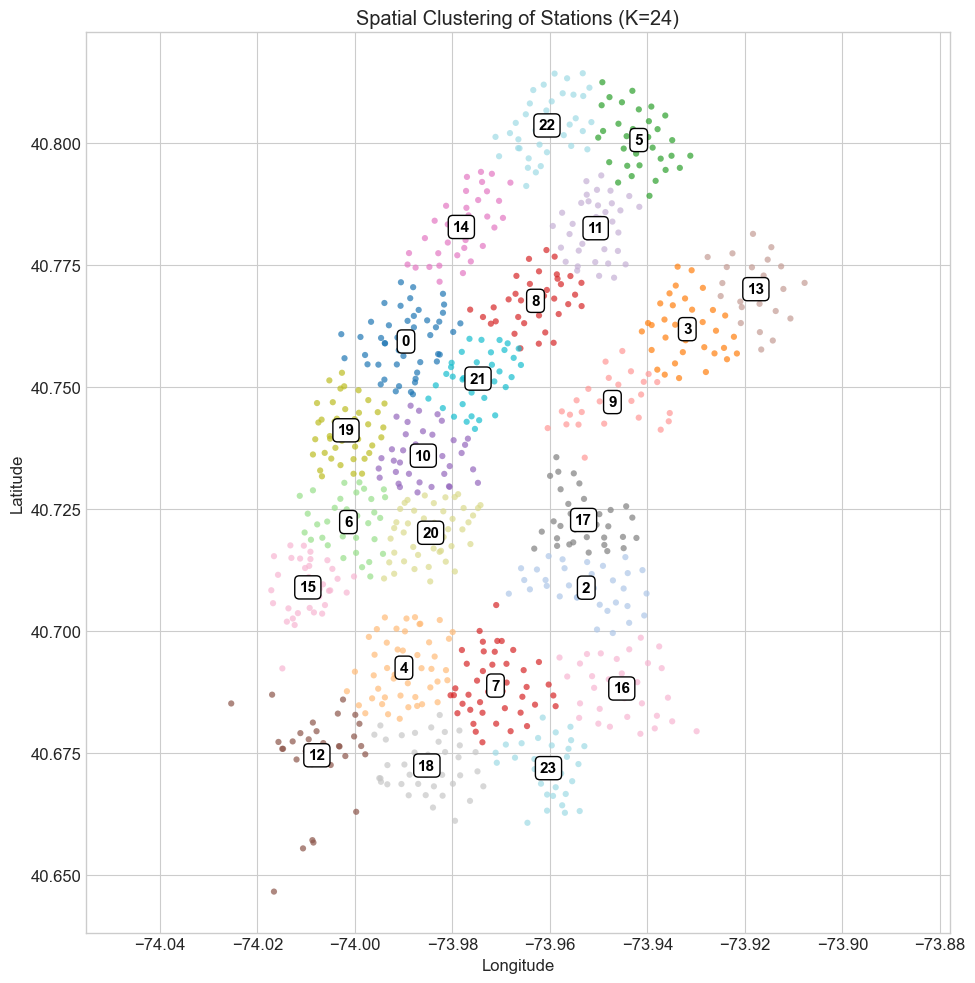

In [ ]:
# --- VISUALIZATION: SPATIAL CLUSTERING ---


# Filter data to only include NYC area
nyc_stations = stations_df[
    (stations_df['lat'] > 40.60) & (stations_df['lat'] < 40.90) &
    (stations_df['lon'] > -74.05) & (stations_df['lon'] < -73.85)
]

plt.figure(figsize=(10, 10)) # Bigger size to accommodate labels

# Plot the points
plt.scatter(nyc_stations['lon'], nyc_stations['lat'], c=nyc_stations['cluster'], 
            cmap='tab20', s=20, alpha=0.7, edgecolor='none')


# We group by cluster to find the average lat/lon (the center) of each group
cluster_centers = nyc_stations.groupby('cluster')[['lat', 'lon']].mean()

# Annotate each cluster center with its cluster ID
for cluster_id, row in cluster_centers.iterrows():
    plt.text(
        row['lon'], row['lat'],     
        str(cluster_id),            
        fontsize=11, 
        weight='bold',
        color='black',
        ha='center', va='center',   
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=1)
    )

plt.title(f"Spatial Clustering of Stations (K={K})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal') 

plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig1_Spatial_Clustering.png', dpi=300)
plt.show()

In [ ]:
# Elbow curve to inspect inertia across K values
lat0 = float(station_master["lat"].mean())
X = np.column_stack([
    station_master["lat"].to_numpy(),
    station_master["lon"].to_numpy() * np.cos(np.deg2rad(lat0)),
])

K_VALUES = list(range(4, 31))  
inertias = []
for K in K_VALUES:
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_) 

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(K_VALUES, inertias, marker="o")
ax.set_title("Elbow Curve — KMeans Distortion (Inertia)")
ax.set_xlabel("K (number of clusters)")
ax.set_ylabel("Distortion / Inertia (lower is better)")

k_mark = 24
if k_mark in K_VALUES:
    ax.axvline(k_mark, linestyle="--", linewidth=1)
    ax.text(k_mark + 0.2, np.interp(k_mark, K_VALUES, inertias),
            f"K={k_mark}", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

display(pd.DataFrame({"K": K_VALUES, "inertia": inertias}).head(25))

In [ ]:
# DATA AGGREGATION 

# Create a mapping dictionary for fast lookups
station_to_cluster = stations_df['cluster'].to_dict()

# Prepare buckets for aggregation
# Key: (Timestamp_Hour, Cluster_ID), Value: Count
pickup_counts = {}
dropoff_counts = {}

# Process file in chunks to keep RAM usage low (Intelligent Data Engineering)
for chunk in pd.read_csv(DATA_PATH, chunksize=chunksize, 
                         usecols=['starttime', 'stoptime', 'start_station_id', 'end_station_id']):
    
    # Convert strings to datetime (fast format)
    chunk['start_hour'] = pd.to_datetime(chunk['starttime']).dt.floor('h')
    chunk['end_hour'] = pd.to_datetime(chunk['stoptime']).dt.floor('h')
    
    # Map clusters
    chunk['start_cluster'] = chunk['start_station_id'].map(station_to_cluster)
    chunk['end_cluster'] = chunk['end_station_id'].map(station_to_cluster)
    
    # Aggregate Pickups
    for (ts, cid), count in chunk.groupby(['start_hour', 'start_cluster']).size().items():
        pickup_counts[(ts, cid)] = pickup_counts.get((ts, cid), 0) + count
        
    # Aggregate Dropoffs
    for (ts, cid), count in chunk.groupby(['end_hour', 'end_cluster']).size().items():
        dropoff_counts[(ts, cid)] = dropoff_counts.get((ts, cid), 0) + count


# Convert dictionaries to DataFrames
df_pick = pd.Series(pickup_counts).reset_index()
df_pick.columns = ['ts', 'cluster_id', 'pickups']

df_drop = pd.Series(dropoff_counts).reset_index()
df_drop.columns = ['ts', 'cluster_id', 'dropoffs']

# Merge full timeline (Outer Join ensures we don't lose data)
df_hourly = pd.merge(df_pick, df_drop, on=['ts', 'cluster_id'], how='outer').fillna(0)
df_hourly['cluster_id'] = df_hourly['cluster_id'].astype(int)
df_hourly = df_hourly.sort_values(['cluster_id', 'ts'])

# IMPORTANT: Reindexing to fill missing hours with 0 (Theory: Temporal Continuity)
# We must ensure every hour is present for the lags to work correctly.
full_idx = pd.date_range(start=df_hourly['ts'].min(), end=df_hourly['ts'].max(), freq='h')
mux = pd.MultiIndex.from_product([df_hourly['cluster_id'].unique(), full_idx], names=['cluster_id', 'ts'])
df_hourly = df_hourly.set_index(['cluster_id', 'ts']).reindex(mux, fill_value=0).reset_index()

display(df_hourly.head())

Raw aggregation done. Converting to DataFrame...
Aggregation Complete. Dataset shape: (214488, 4)


,cluster_id,ts,pickups,dropoffs
0,0,2018-01-01 00:00:00,15.0,5.0
1,0,2018-01-01 01:00:00,17.0,19.0
2,0,2018-01-01 02:00:00,8.0,11.0
3,0,2018-01-01 03:00:00,9.0,9.0
4,0,2018-01-01 04:00:00,6.0,3.0


In [16]:
# TASK 2: PREDICTION MODEL


target_cluster = df_hourly.groupby('cluster_id')['pickups'].sum().idxmax()
print(f"Modeling Representative Cluster: {target_cluster}")

# Filter data
data = df_hourly[df_hourly['cluster_id'] == target_cluster].copy()
data = data.set_index('ts').sort_index()

# --- Features ---
# 1. Lags: 1h, 24h, 168h
data['lag_1h'] = data['pickups'].shift(1)
data['lag_24h'] = data['pickups'].shift(24)
data['lag_168h'] = data['pickups'].shift(168)

# 2. Calendar Features: Capture human behavior patterns
data['hour_of_day'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

# Drop initial NaNs from lags
data = data.dropna()

# --- Train/Test Split ---
# Requirement: Train = Jan-Oct, Test = Nov-Dec
train_mask = data.index.month <= 10
test_mask = data.index.month > 10

X_train = data.loc[train_mask, ['lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']]
y_train = data.loc[train_mask, 'pickups']
y_train_drop = data.loc[train_mask, 'dropoffs'] 

X_test = data.loc[test_mask, ['lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']]
y_test = data.loc[test_mask, 'pickups']
y_test_drop = data.loc[test_mask, 'dropoffs']

# --- Modeling (Ridge Regression) ---
model_pickups = Ridge(alpha=1.0)
model_pickups.fit(X_train, y_train)

model_dropoffs = Ridge(alpha=1.0)
model_dropoffs.fit(X_train, y_train_drop) 

# Predictions
y_pred = model_pickups.predict(X_test)
y_pred = np.maximum(y_pred, 0) 

y_pred_drop = model_dropoffs.predict(X_test)
y_pred_drop = np.maximum(y_pred_drop, 0)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R2: {r2:.3f}")

Modeling Representative Cluster: 0
RMSE: 87.34, R2: 0.794


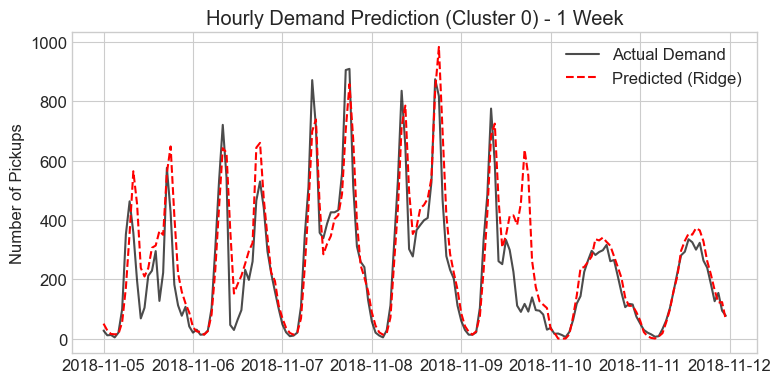

In [ ]:
# --- VISUALIZATION: PREDCITION MODEL ---
zoom_start = '2018-11-05' # A Monday
zoom_end = '2018-11-12'
zoom_mask = (y_test.index >= zoom_start) & (y_test.index < zoom_end)

plt.figure(figsize=(8, 4))
plt.plot(y_test.index[zoom_mask], y_test[zoom_mask], label='Actual Demand', color='black', alpha=0.7)
plt.plot(y_test.index[zoom_mask], y_pred[zoom_mask], label='Predicted (Ridge)', color='red', linestyle='--')
plt.title(f"Hourly Demand Prediction (Cluster {target_cluster}) - 1 Week")
plt.ylabel("Number of Pickups")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig2_Forecast_Zoom.png', dpi=300)
plt.show()

In [19]:
# REBALANCING OPTIMIZATION


# We look at the predicted flows for a specific day in the test set.
# This simulates running the model "at the end of a day" for the next 24h.
analysis_day = '2018-11-07' 
day_mask = (y_test.index.strftime('%Y-%m-%d') == analysis_day)

# Get predicted flows for that day
pred_arrivals = y_pred_drop[day_mask]
pred_departures = y_pred[day_mask]
hours = y_test.index[day_mask]

# Net Flow = Incoming - Outgoing
net_flow = pred_arrivals - pred_departures

# Cumulative Inventory Change
# Assumed we start with 0 bikes
cumulative_inventory = np.cumsum(net_flow)

# The minimum value of the cumulative sum represents the maximum deficit.
# We must stage enough bikes at the start to cover this deficit.
min_inventory = np.min(cumulative_inventory)
bikes_needed = abs(min(0, min_inventory))

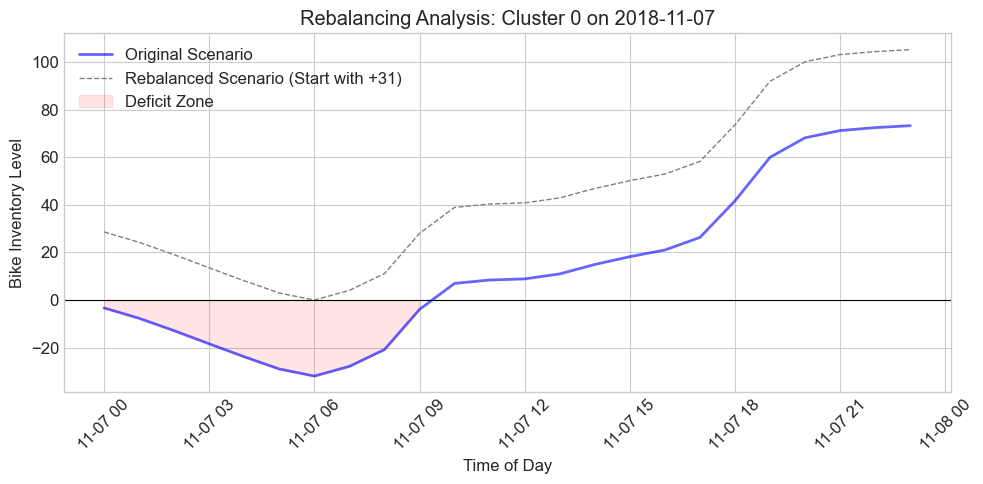

In [28]:
# --- VISUALIZATION: REBALANCING ---

df_rebal = pd.DataFrame({
    'Hour': hours,
    'Net_Flow': net_flow,
    'Inventory_Change': cumulative_inventory
})

# Safe inventory
df_rebal['Safe_Inventory'] = df_rebal['Inventory_Change'] + bikes_needed

plt.figure(figsize=(10, 5)) # Slightly wider for clarity


plt.plot(df_rebal['Hour'], df_rebal['Inventory_Change'], 
         label='Original Scenario', color='blue', linewidth=2, alpha=0.6)


plt.plot(df_rebal['Hour'], df_rebal['Safe_Inventory'], 
         label=f'Rebalanced Scenario (Start with +{int(bikes_needed)})', 
         color='grey', linestyle='--', linewidth=1)

plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.fill_between(df_rebal['Hour'], df_rebal['Inventory_Change'], 0, 
                 where=(df_rebal['Inventory_Change'] < 0), 
                 color='red', alpha=0.1, label='Deficit Zone')

plt.title(f"Rebalancing Analysis: Cluster {target_cluster} on {analysis_day}")
plt.ylabel("Bike Inventory Level")
plt.xlabel("Time of Day")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(FIG_DIR / 'Fig3_Rebalancing_Comparison.png', dpi=300)
plt.show()